# Predicting Dropouts on a MOOC Learning Platform

Matt Menzenski and Kaleb Goering

In [63]:
from __future__ import print_function, division

import math
import numpy as np
import os
import pandas as pd
import time

In [2]:
# Matthews Correlation Coefficient
# expects input of the form [[9713.0, 5263.0], [5599.0, 51750.0]]
# which is [[tpos, fpos], [fneg, tneg]]
def mcc(l):
    tpos, fpos, fneg, tneg = l[0][0], l[0][1], l[1][0], l[1][1]
    num = (tpos * tneg - fpos * fneg)
    den = (tpos + fpos) * (tpos + fneg) * (tneg + fpos) * (tneg + fneg)
    return num / math.sqrt(den)

## Data Preprocessing

This code notebook assumes the following directory structure:

```
mattmenzenski$ tree
.
├── RevisedAnalysis.ipynb
└── newdatafiles
    ├── EECS738_DataDescription.txt
    ├── EECS738_Test.csv
    └── EECS738_Train.csv
```

### Load and examine the data set

In [3]:
DATA_DIR = 'newdatafiles/'
RAW_DATA_FILE = 'EECS738_train.csv'
CLEAN_DATA_FILE = 'cleandata.csv'

training_file = os.path.join(DATA_DIR, RAW_DATA_FILE)

We perform two preliminary operations to prepare the training data set for analysis:

* Add a header row with a unique identifier for each column in the dataset:

In [4]:
# Column 01 is a unique identifier
col_ID = ['ID']
# Column 02 is the class label
col_Lbl = ['Lbl']
# Columns 03 through 16 are Course-related features, so we'll use C for them
cols_C = ['C{}'.format(str(i).rjust(2, '0')) for i in range(3, 17)]
# Columns 17 through 26 are User-related features, so we'll use U for them
cols_U = ['U{}'.format(str(i).rjust(2, '0')) for i in range(17, 27)]
# Columns 27 through 52 are Enrollment-related features, so we'll use E for them
cols_E = ['E{}'.format(str(i).rjust(2, '0')) for i in range(27, 53)]
# Create one list with all column names
headers = [i for l in [col_ID, col_Lbl, cols_C, cols_U, cols_E] for i in l]

training_data = pd.read_csv(training_file, header=False)
training_data.columns = headers

* Replace the original integer values of the class labels (in the second column) with string equivalents. This prevents an error when using Weka's J48 classifier (which requires nonnumeric class labels).

In [5]:
replacements = {0: 'zero', 1: 'one'}
training_data['Lbl'] = training_data['Lbl'].map(replacements)

training_data.head()

,ID,Lbl,C03,C04,C05,C06,C07,C08,C09,C10,...,E43,E44,E45,E46,E47,E48,E49,E50,E51,E52
0,10000,zero,712,7,222,110,0,0,3669,310966,...,0,1,0,1,2,0.001,5918,25023,52,22
1,100002,one,334,12,53,65,1,0,13879,767680,...,0,1,0,0,2,0.000,0,0,0,1
2,100003,one,334,12,53,65,1,0,13879,767680,...,0,1,0,0,1,0.000,0,0,0,0
3,100006,one,385,12,17,132,0,0,1978,64964,...,0,1,0,3,1,0.000,0,0,0,3
4,100007,one,564,14,64,133,6,0,5026,177477,...,0,1,0,2,1,0.000,0,0,0,2


Finally, we need to save the preprocessed data as a CSV file, since Weka can't import a `pandas.DataFrame` object directly. We'll quote strings and remove the index column which `pandas` added.

In [6]:
training_data.to_csv(
    path_or_buf=os.path.join(DATA_DIR, CLEAN_DATA_FILE), quotechar="'",
    index=False)

## Part One: Building and Evaluating Classifiers with Default Parameters

#### Setting up the Environment

First we need to start the Java virtual machine and locate the directory with the data. (This does require that the `weka.jar` file can be found by the Java CLASSPATH.)

In [7]:
import weka.core.jvm as jvm
jvm.start()

Then we need to set up the data loader for CSV files.

In [8]:
from weka.core.converters import Loader
loader = Loader(classname="weka.core.converters.CSVLoader")

Load the data file and specify that the label is found in the second column.

In [9]:
data = loader.load_file(DATA_DIR + CLEAN_DATA_FILE)
data.class_index = 1 # first column is enrollment ID, second column is label

In [10]:
from weka.classifiers import Classifier, Evaluation
from weka.core.classes import Random

### 1. J48 Classifier

Construct a classifier for the data.

In [11]:
from weka.classifiers import Classifier
weka_j48 = Classifier(classname="weka.classifiers.trees.J48") # use default (-C=0.25)
# weka_j48 = Classifier(classname="weka.classifiers.trees.J48", options=["-C", "0.3"])
time_start = int(time.time() * 1000)
weka_j48.build_classifier(data)
time_stop = int(time.time() * 1000)
time_interval = (time_stop - time_start) / 1000
print("The J48 classifier took {} seconds to build.".format(time_interval))

The J48 classifier took 39.039 seconds to build.


Output some predictions.

In [12]:
for index, instance in enumerate(data):
    if index <= 10:
        prediction = weka_j48.classify_instance(instance)
        distribution = weka_j48.distribution_for_instance(instance)
        print("{}: prediction = {}, class distribution = {}".format(
            str(index + 1).rjust(2, ' '), prediction, distribution))

 1: prediction = 0.0, class distribution = [ 1.  0.]
 2: prediction = 1.0, class distribution = [ 0.07080634  0.92919366]
 3: prediction = 1.0, class distribution = [ 0.04225726  0.95774274]
 4: prediction = 1.0, class distribution = [ 0.04225726  0.95774274]
 5: prediction = 1.0, class distribution = [ 0.04225726  0.95774274]
 6: prediction = 1.0, class distribution = [ 0.04225726  0.95774274]
 7: prediction = 0.0, class distribution = [ 0.91544118  0.08455882]
 8: prediction = 1.0, class distribution = [ 0.04225726  0.95774274]
 9: prediction = 1.0, class distribution = [ 0.04225726  0.95774274]
10: prediction = 1.0, class distribution = [ 0.04225726  0.95774274]
11: prediction = 1.0, class distribution = [ 0.04225726  0.95774274]


Print the model.

In [97]:
# commenting out because it's very long
#print(weka_j48)

Draw a graph. (Commented out because this graph is way, way too large to display—it triggers a DecompressionBombWarning).

In [14]:
#import weka.plot.graph as graph
#graph.plot_dot_graph(weka_j48.graph)

### 2. Naive Bayes Classifier

Construct a classifier for the data.

In [15]:
from weka.classifiers import Classifier
weka_naive_bayes = Classifier(classname="weka.classifiers.bayes.NaiveBayes")
time_start = int(time.time() * 1000)
weka_naive_bayes.build_classifier(data)
time_stop = int(time.time() * 1000)
time_interval = (time_stop - time_start) / 1000
print("The Naive Bayes classifier took {} seconds to build.".format(time_interval))

The Naive Bayes classifier took 1.115 seconds to build.


Output some predictions.

In [16]:
for index, instance in enumerate(data):
    if index <= 10:
        prediction = weka_naive_bayes.classify_instance(instance)
        distribution = weka_naive_bayes.distribution_for_instance(instance)
        print("{}: prediction = {}, class distribution = {}".format(
            str(index + 1).rjust(2, ' '), prediction, distribution))

 1: prediction = 0.0, class distribution = [  1.00000000e+00   2.42365505e-22]
 2: prediction = 1.0, class distribution = [  3.24058041e-11   1.00000000e+00]
 3: prediction = 1.0, class distribution = [  2.47992231e-20   1.00000000e+00]
 4: prediction = 1.0, class distribution = [  4.47827554e-14   1.00000000e+00]
 5: prediction = 1.0, class distribution = [  1.95441454e-18   1.00000000e+00]
 6: prediction = 1.0, class distribution = [  5.76455193e-18   1.00000000e+00]
 7: prediction = 0.0, class distribution = [  1.00000000e+000   2.22508080e-101]
 8: prediction = 1.0, class distribution = [  4.73543565e-16   1.00000000e+00]
 9: prediction = 1.0, class distribution = [  1.38167414e-13   1.00000000e+00]
10: prediction = 1.0, class distribution = [  7.03733253e-20   1.00000000e+00]
11: prediction = 1.0, class distribution = [  4.15138710e-14   1.00000000e+00]


Print the model.

In [96]:
# commenting out because it's very long
#print(weka_naive_bayes)

### 3. Logistic Classifier

Construct a classifier for the data.

In [18]:
from weka.classifiers import Classifier
weka_logistic = Classifier(classname="weka.classifiers.functions.Logistic")
time_start = int(time.time() * 1000)
weka_logistic.build_classifier(data)
time_stop = int(time.time() * 1000)
time_interval = (time_stop - time_start) / 1000
print("The Logistic classifier took {} seconds to build.".format(time_interval))

The Logistic classifier took 11.392 seconds to build.


Output some predictions.

In [19]:
for index, instance in enumerate(data):
    if index <= 10:
        prediction = weka_logistic.classify_instance(instance)
        distribution = weka_logistic.distribution_for_instance(instance)
        print("{}: prediction = {}, class distribution = {}".format(
            str(index + 1).rjust(2, ' '), prediction, distribution))

 1: prediction = 1.0, class distribution = [ 0.43447646  0.56552354]
 2: prediction = 1.0, class distribution = [ 0.02622812  0.97377188]
 3: prediction = 1.0, class distribution = [ 0.02023621  0.97976379]
 4: prediction = 1.0, class distribution = [ 0.01948813  0.98051187]
 5: prediction = 1.0, class distribution = [ 0.01391849  0.98608151]
 6: prediction = 1.0, class distribution = [ 0.0205215  0.9794785]
 7: prediction = 0.0, class distribution = [ 0.77893358  0.22106642]
 8: prediction = 1.0, class distribution = [ 0.04177864  0.95822136]
 9: prediction = 1.0, class distribution = [ 0.02687556  0.97312444]
10: prediction = 1.0, class distribution = [ 0.0253111  0.9746889]
11: prediction = 1.0, class distribution = [ 0.03442926  0.96557074]


Print the model.

In [95]:
# commenting out because it's very long
#print(weka_logistic)

## Measuring Classifier Accuracy

First we need to set up and initialize an `Evaluation` instance.

In [21]:
from weka.classifiers import Evaluation
from weka.core.classes import Random

Conduct ten-fold cross-validation on the J48 classifier.

In [22]:
evaluation_j48 = Evaluation(data)
time_start = int(time.time() * 1000)
evaluation_j48.crossvalidate_model(weka_j48, data, 10, Random(1))
time_stop = int(time.time() * 1000)
time_interval = (time_stop - time_start) / 1000
print("A ten-fold cross-validation of the J48 classifier took {} seconds.".format(
        time_interval))
print(evaluation_j48.summary())

A ten-fold cross-validation of the J48 classifier took 325.112 seconds.

Correctly Classified Instances       61645               85.2333 %
Incorrectly Classified Instances     10680               14.7667 %
Kappa statistic                          0.5199
Mean absolute error                      0.1847
Root mean squared error                  0.3673
Relative absolute error                 56.2465 %
Root relative squared error             90.6542 %
Coverage of cases (0.95 level)          91.5009 %
Mean rel. region size (0.95 level)      68.598  %
Total Number of Instances            72325     



In [23]:
print("Percent Correct: {}".format(evaluation_j48.percent_correct))
print("Number Incorrect: {}".format(evaluation_j48.incorrect))

Percent Correct: 85.2333218113
Number Incorrect: 10680.0


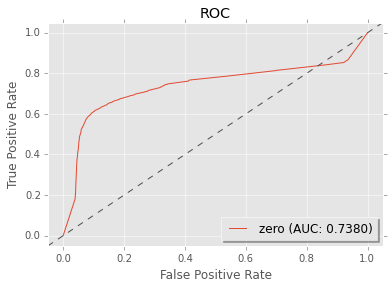

In [24]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import weka.plot.classifiers as plcls # matplotlib is requires
plcls.plot_roc(evaluation_j48, wait=True)

Conduct ten-fold cross-validation on the Naive Bayes classifier.

In [25]:
evaluation_naive_bayes = Evaluation(data)
time_start = int(time.time() * 1000)
evaluation_naive_bayes.crossvalidate_model(weka_naive_bayes, data, 10, Random(1))
time_stop = int(time.time() * 1000)
time_interval = (time_stop - time_start) / 1000
print("A ten-fold cross-validation of the Naive Bayes classifier took {} seconds.".format(
        time_interval))
print(evaluation_naive_bayes.summary())

A ten-fold cross-validation of the Naive Bayes classifier took 8.634 seconds.

Correctly Classified Instances       61463               84.9817 %
Incorrectly Classified Instances     10862               15.0183 %
Kappa statistic                          0.5464
Mean absolute error                      0.1508
Root mean squared error                  0.3817
Relative absolute error                 45.9238 %
Root relative squared error             94.2049 %
Coverage of cases (0.95 level)          86.3616 %
Mean rel. region size (0.95 level)      51.476  %
Total Number of Instances            72325     



In [26]:
print("Percent Correct: {}".format(evaluation_naive_bayes.percent_correct))
print("Number Incorrect: {}".format(evaluation_naive_bayes.incorrect))

Percent Correct: 84.981679917
Number Incorrect: 10862.0


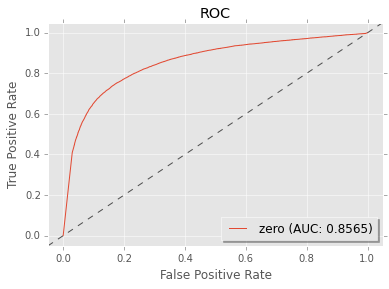

In [27]:
%matplotlib inline
import weka.plot.classifiers as plcls # matplotlib is requires
plcls.plot_roc(evaluation_naive_bayes, wait=True)

In [28]:
list = evaluation_naive_bayes.confusion_matrix.tolist()
print(mcc(list))

0.54646559932


Conduct ten-fold cross-validation on the Logistic classifier.

In [29]:
evaluation_logistic = Evaluation(data)
time_start = int(time.time() * 1000)
evaluation_logistic.crossvalidate_model(weka_logistic, data, 10, Random(1))
time_stop = int(time.time() * 1000)
time_interval = (time_stop - time_start) / 1000
print("A ten-fold cross-validation of the Logistic classifier took {} seconds.".format(
        time_interval))
print(evaluation_logistic.summary())

A ten-fold cross-validation of the Logistic classifier took 90.088 seconds.

Correctly Classified Instances       63396               87.6543 %
Incorrectly Classified Instances      8929               12.3457 %
Kappa statistic                          0.5817
Mean absolute error                      0.1889
Root mean squared error                  0.3068
Relative absolute error                 57.5266 %
Root relative squared error             75.712  %
Coverage of cases (0.95 level)          98.7777 %
Mean rel. region size (0.95 level)      81.3059 %
Total Number of Instances            72325     



In [30]:
print("Percent Correct: {}".format(evaluation_logistic.percent_correct))
print("Number Incorrect: {}".format(evaluation_logistic.incorrect))

Percent Correct: 87.6543380574
Number Incorrect: 8929.0


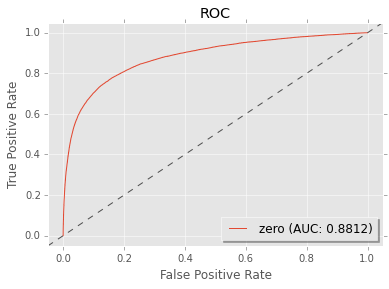

In [31]:
%matplotlib inline
import weka.plot.classifiers as plcls # matplotlib is required
plcls.plot_roc(evaluation_logistic, wait=True)

### Conclusions

We built three classifiers for the training data set using Weka's default parameters and then measured the accuracy of those three classifiers on the same training set using ten-fold cross-validation.

1. The J48 classifier correctly classified 85.34% of instances.
1. The Naive Bayes classifier correctly classified 84.95% of instances.
1. The Logistic classifier correctly classified 87.64% of instances.

We thus conclude that of these three, the Logistic classifier is the most accurate when using the default parameters.

### Ending the Script

Uncomment this next line to end the script's Java virtual machine.

In [32]:
#jvm.stop()

## Part Two: Averaging from Multiple Iterations

In this part of the project, we continue to use the default parameters of the three models, but we test them with 20 iterations each and report the average accuracy, the area under the ROC curve, and the Matthews Correlation Coefficient for each model. We also report the average time that each training process and evaluation process (a ten-fold cross-validation) takes.

In [57]:
# define a template string we can use to print results
results_template = ("{}\n"
                    "  Results over {} iterations: \n"
                    "    Training time: mean {} seconds, stdev {} seconds\n"
                    "    Accuracy: mean {} percent, stdev {} percent\n"
                    "    Area under ROC curve: mean {}, stdev {}\n"
                    "    Matthews Correlation Coefficient: mean {}, stdev {}\n"
                    "    Ten-fold cross-validation time: mean {} seconds, stdev {} seconds")

### J48 Classifier

In [33]:
j48_results = {
    'train_time': [],
    'accuracy': [],
    'area_under_curve': [],
    'mcc': [],
    'eval_time': [],
}
iterations = 20
for i in xrange(1, iterations + 1):
    # train the classifier
    weka_j48 = Classifier(classname="weka.classifiers.trees.J48")
    train_time_start = int(time.time() * 1000)
    weka_j48.build_classifier(data)
    train_time_stop = int(time.time() * 1000)
    train_time_interval = (train_time_stop - train_time_start) / 1000
    j48_results['train_time'].append(train_time_interval)
    # evaluate it with ten-fold cross-validation
    evaluation_j48 = Evaluation(data)
    eval_time_start = int(time.time() * 1000)
    evaluation_j48.crossvalidate_model(weka_j48, data, 10, Random(1))
    eval_time_stop = int(time.time() * 1000)
    eval_time_interval = (eval_time_stop - eval_time_start) / 1000
    j48_results['eval_time'].append(eval_time_interval)
    j48_results['accuracy'].append(evaluation_j48.percent_correct)
    j48_results['area_under_curve'].append(evaluation_j48.area_under_roc(1))
    j48_results['mcc'].append(mcc(evaluation_j48.confusion_matrix.tolist()))

Results over 20 iterations: 
  Average training time: 37.2439 seconds
  Average accuracy: 85.2333218113 percent
  Average area under ROC curve: 0.73798435131
  Average Matthews Correlation Coefficient: 0.523401362276
  Average ten-fold cross-validation time: 321.09125 seconds


In [65]:
# summarize the results
print(results_template.format(
        'J48 Classifier on Full Dataset'.upper(), iterations,
        np.mean(j48_results['train_time']), np.std(j48_results['train_time']),
        np.mean(j48_results['accuracy']), np.std(j48_results['accuracy']),
        np.mean(j48_results['area_under_curve']), np.std(j48_results['area_under_curve']),
        np.mean(j48_results['mcc']), np.std(j48_results['mcc']),
        np.mean(j48_results['eval_time']), np.std(j48_results['eval_time'])))

J48 CLASSIFIER ON FULL DATASET
  Results over 20 iterations: 
    Training time: mean 37.2439 seconds, stdev 1.20287409566 seconds
    Accuracy: mean 85.2333218113 percent, stdev 1.42108547152e-14 percent
    Area under ROC curve: mean 0.73798435131, stdev 0.0
    Matthews Correlation Coefficient: mean 0.523401362276, stdev 0.0
    Ten-fold cross-validation time: mean 321.09125 seconds, stdev 2.74613154956 seconds


### Naive Bayes Classifier

In [34]:
naive_bayes_results = {
    'train_time': [],
    'accuracy': [],
    'area_under_curve': [],
    'mcc': [],
    'eval_time': [],
    }
iterations = 20
for i in xrange(1, iterations + 1):
    # train the classifier
    weka_naive_bayes = Classifier(classname="weka.classifiers.bayes.NaiveBayes")
    train_time_start = int(time.time() * 1000)
    weka_naive_bayes.build_classifier(data)
    train_time_stop = int(time.time() * 1000)
    train_time_interval = (train_time_stop - train_time_start) / 1000
    naive_bayes_results['train_time'].append(train_time_interval)
    # evaluate it with ten-fold cross-validation
    evaluation_naive_bayes = Evaluation(data)
    eval_time_start = int(time.time() * 1000)
    evaluation_naive_bayes.crossvalidate_model(weka_naive_bayes, data, 10, Random(1))
    eval_time_stop = int(time.time() * 1000)
    eval_time_interval = (eval_time_stop - eval_time_start) / 1000
    naive_bayes_results['eval_time'].append(eval_time_interval)
    naive_bayes_results['accuracy'].append(evaluation_naive_bayes.percent_correct)
    naive_bayes_results['area_under_curve'].append(evaluation_naive_bayes.area_under_roc(1))
    naive_bayes_results['mcc'].append(mcc(evaluation_naive_bayes.confusion_matrix.tolist()))

Results over 20 iterations: 
  Average training time: 0.7117 seconds
  Average accuracy: 84.981679917 percent
  Average area under ROC curve: 0.857948889851
  Average Matthews Correlation Coefficient: 0.54646559932
  Average ten-fold cross-validation time: 8.14895 seconds


In [67]:
# summarize the results
print(results_template.format(
        'Naive Bayes Classifier on Full Dataset'.upper(), iterations,
        np.mean(naive_bayes_results['train_time']), np.std(naive_bayes_results['train_time']),
        np.mean(naive_bayes_results['accuracy']), np.std(naive_bayes_results['accuracy']),
        np.mean(naive_bayes_results['area_under_curve']), np.std(naive_bayes_results['area_under_curve']),
        np.mean(naive_bayes_results['mcc']), np.std(naive_bayes_results['mcc']),
        np.mean(naive_bayes_results['eval_time']), np.std(naive_bayes_results['eval_time'])))

NAIVE BAYES CLASSIFIER ON FULL DATASET
  Results over 20 iterations: 
    Training time: mean 0.7117 seconds, stdev 0.0940984059376 seconds
    Accuracy: mean 84.981679917 percent, stdev 1.42108547152e-14 percent
    Area under ROC curve: mean 0.857948889851, stdev 0.0
    Matthews Correlation Coefficient: mean 0.54646559932, stdev 1.11022302463e-16
    Ten-fold cross-validation time: mean 8.14895 seconds, stdev 0.269235115652 seconds


### Logistic Classifier

In [35]:
logistic_results = {
    'train_time': [],
    'accuracy': [],
    'area_under_curve': [],
    'mcc': [],
    'eval_time': [],
    }
iterations = 20
for i in xrange(1, iterations + 1):
    # train the classifier
    weka_logistic = Classifier(classname="weka.classifiers.functions.Logistic")
    train_time_start = int(time.time() * 1000)
    weka_logistic.build_classifier(data)
    train_time_stop = int(time.time() * 1000)
    train_time_interval = (train_time_stop - train_time_start) / 1000
    logistic_results['train_time'].append(train_time_interval)
    # evaluate it with ten-fold cross-validation
    evaluation_logistic = Evaluation(data)
    eval_time_start = int(time.time() * 1000)
    evaluation_logistic.crossvalidate_model(weka_logistic, data, 10, Random(1))
    eval_time_stop = int(time.time() * 1000)
    eval_time_interval = (eval_time_stop - eval_time_start) / 1000
    logistic_results['eval_time'].append(eval_time_interval)
    logistic_results['accuracy'].append(evaluation_logistic.percent_correct)
    logistic_results['area_under_curve'].append(evaluation_logistic.area_under_roc(1))
    logistic_results['mcc'].append(mcc(evaluation_logistic.confusion_matrix.tolist()))

Results over 20 iterations: 
  Average training time: 10.4326 seconds
  Average accuracy: 87.6543380574 percent
  Average area under ROC curve: 0.8812323319
  Average Matthews Correlation Coefficient: 0.592735418698
  Average ten-fold cross-validation time: 91.05705 seconds


In [69]:
# summarize the results
print(results_template.format(
        'Logistic Classifier on Full Dataset'.upper(), iterations,
        np.mean(logistic_results['train_time']), np.std(logistic_results['train_time']),
        np.mean(logistic_results['accuracy']), np.std(logistic_results['accuracy']),
        np.mean(logistic_results['area_under_curve']), np.std(logistic_results['area_under_curve']),
        np.mean(logistic_results['mcc']), np.std(logistic_results['mcc']),
        np.mean(logistic_results['eval_time']), np.std(logistic_results['eval_time'])))

LOGISTIC CLASSIFIER ON FULL DATASET
  Results over 20 iterations: 
    Training time: mean 10.4326 seconds, stdev 0.313756019863 seconds
    Accuracy: mean 87.6543380574 percent, stdev 1.42108547152e-14 percent
    Area under ROC curve: mean 0.8812323319, stdev 0.0
    Matthews Correlation Coefficient: mean 0.592735418698, stdev 0.0
    Ten-fold cross-validation time: mean 91.05705 seconds, stdev 0.608161695193 seconds


## Feature Selection

In [36]:
from weka.attribute_selection import ASSearch, ASEvaluation, AttributeSelection

search = ASSearch(classname='weka.attributeSelection.BestFirst',
                  options=['-D', '1', '-N', '5'])
evaluator = ASEvaluation(classname="weka.attributeSelection.CfsSubsetEval",
                         options=["-P", "1", "-E", "1"])
attsel = AttributeSelection()
attsel.search(search)
attsel.evaluator(evaluator)
attsel.select_attributes(data)

reduced_data = attsel.reduce_dimensionality(data)

print("Number of attributes: {}\nAttributes: {}\n"
      "Result string:\n{}".format(
      attsel.number_attributes_selected, 
      attsel.selected_attributes, attsel.results_string))

Number of attributes: 13
Attributes: [25 32 34 37 38 39 40 41 42 43 46 47 51  1]
Result string:


=== Attribute Selection on all input data ===

Search Method:
	Best first.
	Start set: no attributes
	Search direction: forward
	Stale search after 5 node expansions
	Total number of subsets evaluated: 774
	Merit of best subset found:    0.227

Attribute Subset Evaluator (supervised, Class (nominal): 2 Lbl):
	CFS Subset Evaluator
	Including locally predictive attributes

Selected attributes: 26,33,35,38,39,40,41,42,43,44,47,48,52 : 13
                     U26
                     E33
                     E35
                     E38
                     E39
                     E40
                     E41
                     E42
                     E43
                     E44
                     E47
                     E48
                     E52



### J48 Classifier

In [37]:
j48_results_reduced = {
    'train_time': [],
    'accuracy': [],
    'area_under_curve': [],
    'mcc': [],
    'eval_time': [],
}
iterations = 20
for i in xrange(1, iterations + 1):
    # train the classifier
    weka_j48 = Classifier(classname="weka.classifiers.trees.J48")
    train_time_start = int(time.time() * 1000)
    weka_j48.build_classifier(reduced_data)
    train_time_stop = int(time.time() * 1000)
    train_time_interval = (train_time_stop - train_time_start) / 1000
    j48_results_reduced['train_time'].append(train_time_interval)
    # evaluate it with ten-fold cross-validation
    evaluation_j48 = Evaluation(reduced_data)
    eval_time_start = int(time.time() * 1000)
    evaluation_j48.crossvalidate_model(weka_j48, reduced_data, 10, Random(1))
    eval_time_stop = int(time.time() * 1000)
    eval_time_interval = (eval_time_stop - eval_time_start) / 1000
    j48_results_reduced['eval_time'].append(eval_time_interval)
    j48_results_reduced['accuracy'].append(evaluation_j48.percent_correct)
    j48_results_reduced['area_under_curve'].append(evaluation_j48.area_under_roc(1))
    j48_results_reduced['mcc'].append(mcc(evaluation_j48.confusion_matrix.tolist()))

Results over 20 iterations: 
  Average training time: 9.84345 seconds
  Average accuracy: 86.8233667473 percent
  Average area under ROC curve: 0.810373587749
  Average Matthews Correlation Coefficient: 0.566642249281
  Average ten-fold cross-validation time: 110.93535 seconds


In [70]:
# summarize the results
print(results_template.format(
        'J48 Classifier on Reduced Dataset'.upper(), iterations,
        np.mean(j48_results_reduced['train_time']), np.std(j48_results_reduced['train_time']),
        np.mean(j48_results_reduced['accuracy']), np.std(j48_results_reduced['accuracy']),
        np.mean(j48_results_reduced['area_under_curve']), np.std(j48_results_reduced['area_under_curve']),
        np.mean(j48_results_reduced['mcc']), np.std(j48_results_reduced['mcc']),
        np.mean(j48_results_reduced['eval_time']), np.std(j48_results_reduced['eval_time'])))

J48 CLASSIFIER ON REDUCED DATASET
  Results over 20 iterations: 
    Training time: mean 9.84345 seconds, stdev 0.183189376057 seconds
    Accuracy: mean 86.8233667473 percent, stdev 1.42108547152e-14 percent
    Area under ROC curve: mean 0.810373587749, stdev 0.0
    Matthews Correlation Coefficient: mean 0.566642249281, stdev 1.11022302463e-16
    Ten-fold cross-validation time: mean 110.93535 seconds, stdev 2.18940919599 seconds


### Naive Bayes Classifier

In [38]:
naive_bayes_results_reduced = {
    'train_time': [],
    'accuracy': [],
    'area_under_curve': [],
    'mcc': [],
    'eval_time': [],
    }
iterations = 20
for i in xrange(1, iterations + 1):
    # train the classifier
    weka_naive_bayes = Classifier(classname="weka.classifiers.bayes.NaiveBayes")
    train_time_start = int(time.time() * 1000)
    weka_naive_bayes.build_classifier(reduced_data)
    train_time_stop = int(time.time() * 1000)
    train_time_interval = (train_time_stop - train_time_start) / 1000
    naive_bayes_results_reduced['train_time'].append(train_time_interval)
    # evaluate it with ten-fold cross-validation
    evaluation_naive_bayes = Evaluation(reduced_data)
    eval_time_start = int(time.time() * 1000)
    evaluation_naive_bayes.crossvalidate_model(weka_naive_bayes, reduced_data, 10, Random(1))
    eval_time_stop = int(time.time() * 1000)
    eval_time_interval = (eval_time_stop - eval_time_start) / 1000
    naive_bayes_results_reduced['eval_time'].append(eval_time_interval)
    naive_bayes_results_reduced['accuracy'].append(evaluation_naive_bayes.percent_correct)
    naive_bayes_results_reduced['area_under_curve'].append(evaluation_naive_bayes.area_under_roc(1))
    naive_bayes_results_reduced['mcc'].append(mcc(evaluation_naive_bayes.confusion_matrix.tolist()))

Results over 20 iterations: 
  Average training time: 0.1922 seconds
  Average accuracy: 86.126512271 percent
  Average area under ROC curve: 0.862529456885
  Average Matthews Correlation Coefficient: 0.554512378152
  Average ten-fold cross-validation time: 2.35235 seconds


In [71]:
# summarize the results
print(results_template.format(
        'Naive Bayes Classifier on Reduced Dataset'.upper(), iterations,
        np.mean(naive_bayes_results_reduced['train_time']), np.std(naive_bayes_results_reduced['train_time']),
        np.mean(naive_bayes_results_reduced['accuracy']), np.std(naive_bayes_results_reduced['accuracy']),
        np.mean(naive_bayes_results_reduced['area_under_curve']), np.std(naive_bayes_results_reduced['area_under_curve']),
        np.mean(naive_bayes_results_reduced['mcc']), np.std(naive_bayes_results_reduced['mcc']),
        np.mean(naive_bayes_results_reduced['eval_time']), np.std(naive_bayes_results_reduced['eval_time'])))

NAIVE BAYES CLASSIFIER ON REDUCED DATASET
  Results over 20 iterations: 
    Training time: mean 0.1922 seconds, stdev 0.0353561875773 seconds
    Accuracy: mean 86.126512271 percent, stdev 1.42108547152e-14 percent
    Area under ROC curve: mean 0.862529456885, stdev 1.11022302463e-16
    Matthews Correlation Coefficient: mean 0.554512378152, stdev 1.11022302463e-16
    Ten-fold cross-validation time: mean 2.35235 seconds, stdev 0.278219926497 seconds


### Logistic Classifier

In [39]:
logistic_results_reduced = {
    'train_time': [],
    'accuracy': [],
    'area_under_curve': [],
    'mcc': [],
    'eval_time': [],
    }
iterations = 20
for i in xrange(1, iterations + 1):
    # train the classifier
    weka_logistic = Classifier(classname="weka.classifiers.functions.Logistic")
    train_time_start = int(time.time() * 1000)
    weka_logistic.build_classifier(reduced_data)
    train_time_stop = int(time.time() * 1000)
    train_time_interval = (train_time_stop - train_time_start) / 1000
    logistic_results_reduced['train_time'].append(train_time_interval)
    # evaluate it with ten-fold cross-validation
    evaluation_logistic = Evaluation(reduced_data)
    eval_time_start = int(time.time() * 1000)
    evaluation_logistic.crossvalidate_model(weka_logistic, reduced_data, 10, Random(1))
    eval_time_stop = int(time.time() * 1000)
    eval_time_interval = (eval_time_stop - eval_time_start) / 1000
    logistic_results_reduced['eval_time'].append(eval_time_interval)
    logistic_results_reduced['accuracy'].append(evaluation_logistic.percent_correct)
    logistic_results_reduced['area_under_curve'].append(evaluation_logistic.area_under_roc(1))
    logistic_results_reduced['mcc'].append(mcc(evaluation_logistic.confusion_matrix.tolist()))

Results over 20 iterations: 
  Average training time: 2.73935 seconds
  Average accuracy: 87.2022122364 percent
  Average area under ROC curve: 0.870423814362
  Average Matthews Correlation Coefficient: 0.5732569037
  Average ten-fold cross-validation time: 24.3857 seconds


In [72]:
# summarize the results
print(results_template.format(
        'Logistic Classifier on Reduced Dataset'.upper(), iterations,
        np.mean(logistic_results_reduced['train_time']), np.std(logistic_results_reduced['train_time']),
        np.mean(logistic_results_reduced['accuracy']), np.std(logistic_results_reduced['accuracy']),
        np.mean(logistic_results_reduced['area_under_curve']), np.std(logistic_results_reduced['area_under_curve']),
        np.mean(logistic_results_reduced['mcc']), np.std(logistic_results_reduced['mcc']),
        np.mean(logistic_results_reduced['eval_time']), np.std(logistic_results_reduced['eval_time'])))

LOGISTIC CLASSIFIER ON REDUCED DATASET
  Results over 20 iterations: 
    Training time: mean 2.73935 seconds, stdev 0.0214692221564 seconds
    Accuracy: mean 87.2022122364 percent, stdev 1.42108547152e-14 percent
    Area under ROC curve: mean 0.870423814362, stdev 1.11022302463e-16
    Matthews Correlation Coefficient: mean 0.5732569037, stdev 1.11022302463e-16
    Ten-fold cross-validation time: mean 24.3857 seconds, stdev 0.272551664827 seconds


### Effects of Attribute Selection

In [94]:
import numpy as np

dicts = {
    1: ['J48', j48_results, j48_results_reduced],
    2: ['Naive Bayes', naive_bayes_results, naive_bayes_results_reduced],
    3: ['Logistic', logistic_results, logistic_results_reduced],
}

for l in [dicts[1], dicts[2], dicts[3]]:
    print("Effects of Feature Selection on the {} Classifier".format(l[0]).upper())
    print("\t\t\tFull Dataset\t\tReduced Dataset\t\tDifference")
    print("Mean Training Time:\t{}\t\t\t{}\t\t\t{}".format(
            np.mean(l[1]['train_time']), np.mean(l[2]['train_time']), 
            np.mean(l[2]['train_time']) - np.mean(l[1]['train_time'])))
    print("Mean Accuracy:\t\t{}\t\t{}\t\t{}".format(
            np.mean(l[1]['accuracy']), np.mean(l[2]['accuracy']), 
            np.mean(l[2]['accuracy']) - np.mean(l[1]['accuracy'])))
    print("Mean Area Under Curve:\t{}\t\t{}\t\t{}".format(
            np.mean(l[1]['area_under_curve']), np.mean(l[2]['area_under_curve']), 
            np.mean(l[2]['area_under_curve']) - np.mean(l[1]['area_under_curve'])))
    print("Mean MCC:\t\t{}\t\t{}\t\t{}".format(
            np.mean(l[1]['mcc']), np.mean(l[2]['mcc']), 
            np.mean(l[2]['mcc']) - np.mean(l[1]['mcc'])))
    print("Mean 10-Fold CV Time:\t{}\t\t{}\t\t{}".format(
            str(np.mean(l[1]['eval_time'])).ljust(10, ' '), 
            str(np.mean(l[2]['eval_time'])).ljust(10, ' '), 
            np.mean(l[2]['eval_time']) - np.mean(l[1]['eval_time'])))
    print('\n')

EFFECTS OF FEATURE SELECTION ON THE J48 CLASSIFIER
			Full Dataset		Reduced Dataset		Difference
Mean Training Time:	37.2439			9.84345			-27.40045
Mean Accuracy:		85.2333218113		86.8233667473		1.59004493605
Mean Area Under Curve:	0.73798435131		0.810373587749		0.0723892364385
Mean MCC:		0.523401362276		0.566642249281		0.0432408870055
Mean 10-Fold CV Time:	321.09125 		110.93535 		-210.1559


EFFECTS OF FEATURE SELECTION ON THE NAIVE BAYES CLASSIFIER
			Full Dataset		Reduced Dataset		Difference
Mean Training Time:	0.7117			0.1922			-0.5195
Mean Accuracy:		84.981679917		86.126512271		1.14483235396
Mean Area Under Curve:	0.857948889851		0.862529456885		0.00458056703405
Mean MCC:		0.54646559932		0.554512378152		0.00804677883242
Mean 10-Fold CV Time:	8.14895   		2.35235   		-5.7966


EFFECTS OF FEATURE SELECTION ON THE LOGISTIC CLASSIFIER
			Full Dataset		Reduced Dataset		Difference
Mean Training Time:	10.4326			2.73935			-7.69325
Mean Accuracy:		87.6543380574		87.2022122364		-0.452125820947


## Parameter Optimization

In this section we attempt to optimize the parameters of the Logistic classifier. Even with the default parameters, it's the most accurate of the three classifiers we've built.

In [105]:
test_model = weka_logistic

In [106]:
type(test_model)

weka.classifiers.Classifier

In [114]:
import javabridge
def coefficients(model):
    m = javabridge.call(model.jobject, 'coefficients', '()[[D')
    result = [javabridge.get_env().get_array_length(m)]
    rows = javabridge.get_env().get_object_array_elements(m)
    for row in rows:
        elements = []
        for i, element in enumerate(javabridge.get_env().get_double_array_elements(row)):
            elements.append(float(element))
        result.append(elements)
    return result

In [116]:
coefficients(weka_logistic)

[14,
 [-4.04940132290271],
 [0.08395065966819282],
 [0.011301416583085594],
 [0.16050074495081695],
 [-0.035802582459458464],
 [2.8576360942597026],
 [3.7831564494029477],
 [0.9729805786133152],
 [0.016956508337060455],
 [0.0017345313137402548],
 [-0.02566419191033152],
 [-0.02282338247486531],
 [-94.11231520425851],
 [0.07923377097779989]]

In [119]:
weka_logistic.capabilities

Capabilities: [Nominal attributes, Binary attributes, Unary attributes, Empty nominal attributes, Numeric attributes, Date attributes, Missing values, Nominal class, Binary class, Missing class values]
Dependencies: []
min # Instance: 1

In [125]:
logistic_results_opt = {
    'train_time': [],
    'accuracy': [],
    'area_under_curve': [],
    'mcc': [],
    'eval_time': [],
    }
iterations = 1
for i in xrange(1, iterations + 1):
    for r in [0.00000000001, 0.0000001, 0.0001, 0.01, 0.1, 1]:
        for m in [1, 3, 10, 100]:
            # train the classifier
            weka_logistic = Classifier(classname="weka.classifiers.functions.Logistic",
                                       options=["-R", "{}".format(r), "-M", "{}".format(m)])
            train_time_start = int(time.time() * 1000)
            weka_logistic.build_classifier(reduced_data)
            train_time_stop = int(time.time() * 1000)
            train_time_interval = (train_time_stop - train_time_start) / 1000
            logistic_results_opt['train_time'].append(train_time_interval)
            # evaluate it with ten-fold cross-validation
            evaluation_logistic = Evaluation(data)
            eval_time_start = int(time.time() * 1000)
            evaluation_logistic.crossvalidate_model(weka_logistic, data, 10, Random(1))
            eval_time_stop = int(time.time() * 1000)
            eval_time_interval = (eval_time_stop - eval_time_start) / 1000
            logistic_results_opt['eval_time'].append(eval_time_interval)
            logistic_results_opt['accuracy'].append(evaluation_logistic.percent_correct)
            logistic_results_opt['area_under_curve'].append(evaluation_logistic.area_under_roc(1))
            logistic_results_opt['mcc'].append(mcc(evaluation_logistic.confusion_matrix.tolist()))
            print("{} percent accuracy with ridge of {} and max iterations of {}".format(
                evaluation_logistic.percent_correct, r, m))

83.969581749 percent accuracy with ridge of 1e-11 and max iterations of 1
87.3681299689 percent accuracy with ridge of 1e-11 and max iterations of 3
87.5727618389 percent accuracy with ridge of 1e-11 and max iterations of 10
87.6543380574 percent accuracy with ridge of 1e-11 and max iterations of 100
83.969581749 percent accuracy with ridge of 1e-07 and max iterations of 1
87.3681299689 percent accuracy with ridge of 1e-07 and max iterations of 3
87.5727618389 percent accuracy with ridge of 1e-07 and max iterations of 10
87.6543380574 percent accuracy with ridge of 1e-07 and max iterations of 100
83.969581749 percent accuracy with ridge of 0.0001 and max iterations of 1
87.3681299689 percent accuracy with ridge of 0.0001 and max iterations of 3
87.5727618389 percent accuracy with ridge of 0.0001 and max iterations of 10


KeyboardInterrupt: 

In [ ]:
# summarize the results
print(results_template.format(
        'Logistic Classifier Trained on Reduced Dataset, Tested on Full Dataset ' \
        'With Options ["-R", "0.01"]'.upper(), iterations,
        np.mean(logistic_results['train_time']), np.std(logistic_results['train_time']),
        np.mean(logistic_results['accuracy']), np.std(logistic_results['accuracy']),
        np.mean(logistic_results['area_under_curve']), np.std(logistic_results['area_under_curve']),
        np.mean(logistic_results['mcc']), np.std(logistic_results['mcc']),
        np.mean(logistic_results['eval_time']), np.std(logistic_results['eval_time'])))

In [129]:
print(weka_j48.to_help())

weka.classifiers.trees.J48

DESCRIPTION

Class for generating a pruned or unpruned C4.5 decision tree. For more information, see

Ross Quinlan (1993). C4.5: Programs for Machine Learning. Morgan Kaufmann Publishers, San Mateo, CA.

OPTIONS

-U
	Use unpruned tree.

-O
	Do not collapse tree.

-C <pruning confidence>
	Set confidence threshold for pruning.
	(default 0.25)

-M <minimum number of instances>
	Set minimum number of instances per leaf.
	(default 2)

-R
	Use reduced error pruning.

-N <number of folds>
	Set number of folds for reduced error
	pruning. One fold is used as pruning set.
	(default 3)

-B
	Use binary splits only.

-S
	Do not perform subtree raising.

-L
	Do not clean up after the tree has been built.

-A
	Laplace smoothing for predicted probabilities.

-J
	Do not use MDL correction for info gain on numeric attributes.

-Q <seed>
	Seed for random data shuffling (default 1).

-doNotMakeSplitPointActualValue
	Do not make split point actual value.

-output-debug-info
	If 

In [130]:
print(weka_naive_bayes.to_help())

weka.classifiers.bayes.NaiveBayes

DESCRIPTION

Class for a Naive Bayes classifier using estimator classes. Numeric estimator precision values are chosen based on analysis of the  training data. For this reason, the classifier is not an UpdateableClassifier (which in typical usage are initialized with zero training instances) -- if you need the UpdateableClassifier functionality, use the NaiveBayesUpdateable classifier. The NaiveBayesUpdateable classifier will  use a default precision of 0.1 for numeric attributes when buildClassifier is called with zero training instances.

For more information on Naive Bayes classifiers, see

George H. John, Pat Langley: Estimating Continuous Distributions in Bayesian Classifiers. In: Eleventh Conference on Uncertainty in Artificial Intelligence, San Mateo, 338-345, 1995.

OPTIONS

-K
	Use kernel density estimator rather than normal
	distribution for numeric attributes

-D
	Use supervised discretization to process numeric attributes


-O
	Display mod

In [131]:
print(weka_logistic.to_help())

weka.classifiers.functions.Logistic

DESCRIPTION

Class for building and using a multinomial logistic regression model with a ridge estimator.

There are some modifications, however, compared to the paper of leCessie and van Houwelingen(1992): 

If there are k classes for n instances with m attributes, the parameter matrix B to be calculated will be an m*(k-1) matrix.

The probability for class j with the exception of the last class is

Pj(Xi) = exp(XiBj)/((sum[j=1..(k-1)]exp(Xi*Bj))+1) 

The last class has probability

1-(sum[j=1..(k-1)]Pj(Xi)) 
	= 1/((sum[j=1..(k-1)]exp(Xi*Bj))+1)

The (negative) multinomial log-likelihood is thus: 

L = -sum[i=1..n]{
	sum[j=1..(k-1)](Yij * ln(Pj(Xi)))
	+(1 - (sum[j=1..(k-1)]Yij)) 
	* ln(1 - sum[j=1..(k-1)]Pj(Xi))
	} + ridge * (B^2)

In order to find the matrix B for which L is minimised, a Quasi-Newton Method is used to search for the optimized values of the m*(k-1) variables.  Note that before we use the optimization procedure, we 'squeeze' the mat

In [134]:
naive_bayes_results_opt = {
    'train_time': [],
    'accuracy': [],
    'area_under_curve': [],
    'mcc': [],
    'eval_time': [],
    }
iterations = 4
for i in xrange(1, iterations + 1):
    for opt in [['-K'], ['-D'], []]:
        # train the classifier
        weka_naive_bayes = Classifier(classname="weka.classifiers.bayes.NaiveBayes",
                                   options=opt)
        train_time_start = int(time.time() * 1000)
        weka_naive_bayes.build_classifier(reduced_data)
        train_time_stop = int(time.time() * 1000)
        train_time_interval = (train_time_stop - train_time_start) / 1000
        naive_bayes_results_opt['train_time'].append(train_time_interval)
        # evaluate it with ten-fold cross-validation
        evaluation_naive_bayes = Evaluation(data)
        eval_time_start = int(time.time() * 1000)
        evaluation_naive_bayes.crossvalidate_model(weka_naive_bayes, data, 10, Random(1))
        eval_time_stop = int(time.time() * 1000)
        eval_time_interval = (eval_time_stop - eval_time_start) / 1000
        naive_bayes_results_opt['eval_time'].append(eval_time_interval)
        naive_bayes_results_opt['accuracy'].append(evaluation_naive_bayes.percent_correct)
        naive_bayes_results_opt['area_under_curve'].append(evaluation_naive_bayes.area_under_roc(1))
        naive_bayes_results_opt['mcc'].append(mcc(evaluation_naive_bayes.confusion_matrix.tolist()))
        print("{} percent accuracy with option {}".format(
            evaluation_naive_bayes.percent_correct, opt))

84.0981679917 percent accuracy with option ['-K']
81.4863463533 percent accuracy with option ['-D']
84.981679917 percent accuracy with option []
84.0981679917 percent accuracy with option ['-K']
81.4863463533 percent accuracy with option ['-D']
84.981679917 percent accuracy with option []
84.0981679917 percent accuracy with option ['-K']
81.4863463533 percent accuracy with option ['-D']
84.981679917 percent accuracy with option []
84.0981679917 percent accuracy with option ['-K']
81.4863463533 percent accuracy with option ['-D']
84.981679917 percent accuracy with option []
